Zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp. Zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np:
trainset = ImageFolder("data/train/", transform=train_transform)
Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.
Jako że dane są bardzo duże to umieściłem je na OneDrive:
(train.zip i test_all.zip)

W ramach rozwiązania, proszę oddać przez teamsy plik archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze testowym. BEZ dodatkowych podfolderów i BEZ danych. W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
Pierwszą kolumnę z nazwami plików testowych (uwaga pliki nazywają się np. 850043533599308.JPEG a nie 850043533599308.jpeg, 850043533599308.jpg czy 850043533599308). Proszę zwrócić na to uwagę bo mój skrypt ewaluacyjny inaczej nie zadziała.
Drugą kolumnę z wartościami oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (alfabetycznie startując od zera). Po utworzeniu datasetu w oparciu o ImageFolder klasy powinny się tak przypisać autoamtycznie - mogą to państwo sprawdzić wywołując trainset.classes.

Bardzo proszę nazywać wszystkie przesyłane pliki nazwiskami autorów (najlepiej alfabetycznie). Wyszukiwanie kto podpisał się "predictions.csv", a kto projekt_2.ipynb jest uciążliwe.
Końcowe wyniki obliczał będę w oparciu o zwykłe accuracy (klasy są zbilansowane).
Uwaga: W zadaniu proszę nie wykorzystywać gotowych architektur o których wspominałem na zajęciach. Proszę też nie kopiować gotowych fragmentów (np. bloki resnetowe itp). Ostatnie laboratorium poświęcone będzie dokładnie temu zagadnieniu. Takie rozwiązania nie będą oceniane

W MS Teams przydzieliłem zadanie wszystkim uczestnikom, ale bardzo proszę żeby tylko jeden (dowolny) członek zespołu je zwrócił (proszę się dogadać).
W razie pytań zapraszam do korespondencji lub na konsultacje.


In [53]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [55]:
BATCH_SIZE = 4
TRAIN_DATA_PATH = './data/train'
TEST_DATA_PATH = './data/test_all'

In [56]:
transform = transforms.Compose([
     transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
test_dataset = ImageFolder(root=TRAIN_DATA_PATH, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

folders = sorted(os.listdir(TRAIN_DATA_PATH))
classes = {index: value for index, value in enumerate(folders)}

print(classes)

{0: 'acoustic', 1: 'antenna', 2: 'bacteria', 3: 'battery', 4: 'bean', 5: 'beetle', 6: 'bicycle', 7: 'birch', 8: 'bird', 9: 'bomb', 10: 'bread', 11: 'bridge', 12: 'camera', 13: 'carbon', 14: 'cat', 15: 'corn', 16: 'crab', 17: 'crocodilian', 18: 'echinoderm', 19: 'egg', 20: 'elephant', 21: 'fish', 22: 'flower', 23: 'frog', 24: 'fungus', 25: 'gauge', 26: 'hammer', 27: 'icecream', 28: 'kangaroo', 29: 'memorial', 30: 'monkey', 31: 'motor', 32: 'nest', 33: 'palm', 34: 'pizza', 35: 'pot', 36: 'printer', 37: 'saw', 38: 'snake', 39: 'spice', 40: 'spider', 41: 'spoon', 42: 'squash', 43: 'swine', 44: 'tea', 45: 'tomato', 46: 'towel', 47: 'truck', 48: 'turtle', 49: 'worm'}


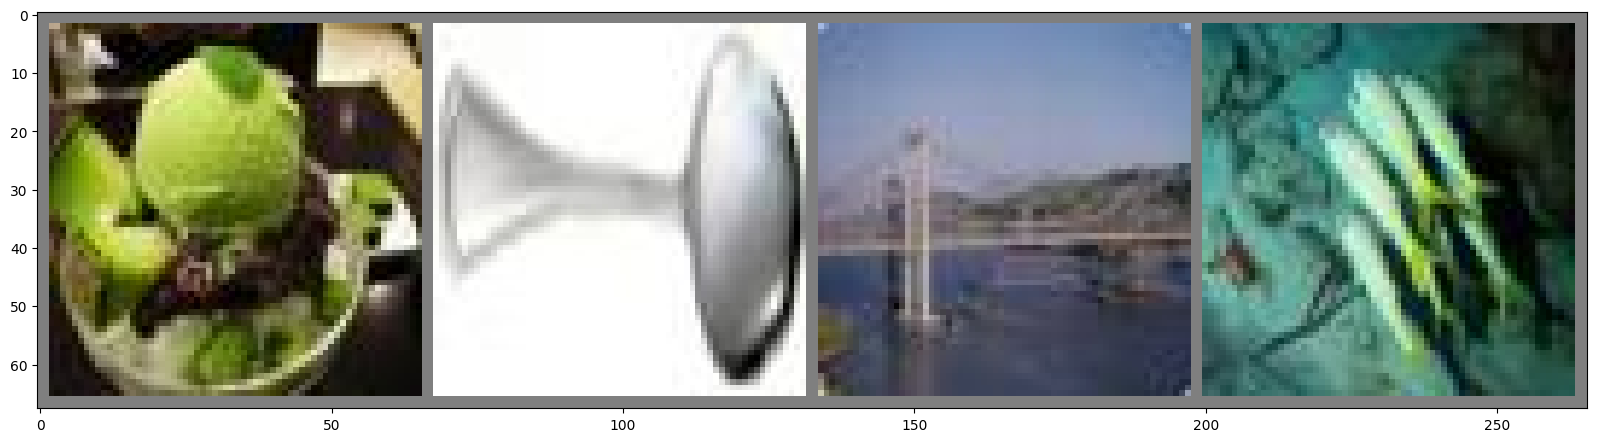

icecream spoon bridge  fish


In [57]:
plt.figure(figsize = (20,10))

images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j].item()] for j in range(BATCH_SIZE)))

In [58]:
# class ImageClassifier(nn.Module):
#     def __init__(self, num_classes=50):
#         super(ImageClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(128 * 8 * 8, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 128)
#         self.fc4 = nn.Linear(128, num_classes)

#         self.pool = nn.MaxPool2d(2, 2)
#         self.flatten = nn.Flatten()
#         self.relu = nn.ReLU()
#         self.out = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.fc4(x)
#         x = self.out(x)
#         return x

In [59]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=50):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(12 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.out = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [60]:
model = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15

model

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=56, bias=True)
  (fc4): Linear(in_features=56, out_features=50, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (out): Softmax(dim=1)
)

In [61]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')


[1/5] loss: 42.736
[2/5] loss: 42.432
[3/5] loss: 42.467


KeyboardInterrupt: 